<a href="https://colab.research.google.com/github/aidins1/Quantized-Auto-Encoder/blob/master/miniworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls 'gdrive/My Drive/BNN-TNN'
!cp 'gdrive/My Drive/BNN-TNN/ternary_ops.py' 'ternary_ops.py'
!cp 'gdrive/My Drive/BNN-TNN/ternary_layers.py' 'ternary_layers.py'
!cp 'gdrive/My Drive/BNN-TNN/binary_ops.py' 'binary_ops.py'
!cp 'gdrive/My Drive/BNN-TNN/binary_layers.py' 'binary_layers.py'

ae_bnn_tnn_weights.h5		e_bnn_tnn_weights.h5
ae_bnn_weights_1024.h5		e_bnn_weights_1024.h5
ae_bnn_weights1.h5		e_tnn_bnn_codeword_weights.h5
ae_bnn_weights2.h5		e_tnn_weights.h5
AE.py				images_np_array.npy
ae_tnn_bnn_codeword_weights.h5	miniworld_data.npy
ae_tnn_weights.h5		ternary_layers.py
binary_layers.py		ternary_ops.py
binary_ops.py


In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import sys

from ternary_ops import ternarize
from ternary_layers import TernaryDense, TernaryConv2D
from binary_ops import binary_tanh as binary_tanh_op
from binary_layers import BinaryDense, BinaryConv2D
from keras.layers import Dense, Dropout,Activation, BatchNormalization, Flatten
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam, RMSprop, Adamax, Nadam, Adadelta, Adagrad
from keras.callbacks import LearningRateScheduler

import keras
img_rows, img_cols = 120,120
print(keras.backend.image_data_format())


input_img = Input(shape=(120,120,3))  # adapt this if using `channels_first` image data format

# x = Conv2D(4, (3, 3), activation='relu', padding='valid', strides=2)(input_img)
# x = Conv2D(8, (3, 3), activation='relu', padding='valid', strides=2)(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='valid', strides=2)(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='valid', strides=2)(x)

# x = Flatten()(x)
# encoded = Dense(64)(x)



def binary_tanh(x):
    return binary_tanh_op(x)

def ternary_tanh(x):
    x = K.clip(x, -1, 1)
    return ternarize(x)

my_epochs = 50
lr_start = 1e-2
lr_start = 1e-1
lr_end = 1e-4
#lr_end = 1e-6 tokhmie
lr_end = 2*1e-5
lr_decay = (lr_end / lr_start)**(1. / my_epochs)

H = 1
kernel_lr_multiplier = 'Glorot'
W_lr_multiplier = 'Glorot'
bias = False

#x = Conv2D(16, (4, 4), activation='relu', padding='valid', strides=2)(input_img)
x = TernaryConv2D(64, kernel_size=(3, 3), H=H, kernel_lr_multiplier=W_lr_multiplier, bias=bias,kernel_initializer='he_normal', padding='valid', strides=2)(input_img)
x = BatchNormalization()(x)
x = Activation(ternary_tanh)(x)


#x = Conv2D(32, (4, 4), activation='relu', padding='valid', strides=2)(x)
x = TernaryConv2D(128, kernel_size=(3, 3), H=H, kernel_lr_multiplier=W_lr_multiplier, bias=bias,kernel_initializer='he_normal', padding='valid', strides=2)(x)
x = BatchNormalization()(x)
x = Activation(ternary_tanh)(x)


#x = Conv2D(64, (4, 4), activation='relu', padding='valid', strides=2)(x)
x = TernaryConv2D(256, kernel_size=(3, 3), H=H, kernel_lr_multiplier=W_lr_multiplier, bias=bias,kernel_initializer='he_normal', padding='valid', strides=2)(x)
x = BatchNormalization()(x)
x = Activation(ternary_tanh)(x)



#x = Conv2D(128, (4, 4), activation='relu', padding='valid', strides=2)(x)
x = TernaryConv2D(512, kernel_size=(3, 3), H=H, kernel_lr_multiplier=W_lr_multiplier, bias=bias,kernel_initializer='he_normal', padding='valid', strides=2)(x)
x = BatchNormalization()(x)
x = Activation(ternary_tanh)(x)


x = Flatten()(x)
x = TernaryDense(1024, H=H, kernel_lr_multiplier=W_lr_multiplier,bias=bias,kernel_initializer='he_normal')(x)
encoded = Activation(ternary_tanh)(x)

x = Dense(18432)(encoded)
x = Reshape([6, 6, 512])(x)
x = Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='valid')(x)
x = Conv2DTranspose(128, (4, 4), strides=2, activation='relu', padding='valid')(x)
x = Conv2DTranspose(64, (5, 5), strides=2, activation='relu', padding='valid')(x)
decoded = Conv2DTranspose(3, (4, 4), strides=2, activation='sigmoid', padding='valid')(x)


encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

print(autoencoder.summary())

print(keras.backend.image_data_format())

autoencoder.compile(optimizer='adam', loss='mse')

Using TensorFlow backend.


channels_last



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





/content/ternary_layers.py:101: UserWarning: Update your `TernaryConv2D` call to the Keras 2 API: `TernaryConv2D(64, kernel_size=(3, 3), kernel_initializer="he_normal", padding="valid", strides=2, use_bias=False)`
  super(TernaryConv2D, self).__init__(filters, **kwargs)


/content/ternary_layers.py:101: UserWarning: Update your `TernaryConv2D` call to the Keras 2 API: `TernaryConv2D(128, kernel_size=(3, 3), kernel_initializer="he_normal", padding="valid", strides=2, use_bias=False)`
  super(TernaryConv2D, self).__init__(filters, **kwargs)
/content/ternary_layers.py:101: UserWarning: Update your `TernaryConv2D` call to the Keras 2 API: `TernaryConv2D(256, kernel_size=(3, 3), kernel_initializer="he_normal", padding="valid", strides=2, use_bias=False)`
  super(TernaryConv2D, self).__init__(filters, **kwargs)
/content/ternary_layers.py:101: UserWarning: Update your `TernaryConv2D` call to the Keras 2 API: `TernaryConv2D(512, kernel_size=(3, 3), kernel_initializer="he_normal", padding="valid", strides=2, use_bias=False)`
  super(TernaryConv2D, self).__init__(filters, **kwargs)
/content/ternary_layers.py:37: UserWarning: Update your `TernaryDense` call to the Keras 2 API: `TernaryDense(1024, kernel_initializer="he_normal", use_bias=False)`
  super(TernaryDens

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
ternary_conv2d_1 (TernaryCon (None, 59, 59, 64)        1728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 59, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 59, 59, 64)        0         
_________________________________________________________________
ternary_conv2d_2 (TernaryCon (None, 29, 29, 128)       73728     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 29, 29, 128)       0   

In [0]:
####### PREP DATA #####
# import numpy as np
# import os
# import cv2


# image_folder = '/content/gdrive/My Drive/datasets/sidewalk/' ### YOUR IMAGE FOLDER
# images = [im for im in os.listdir(image_folder) if im.endswith('.png')]
# images = np.array(images)
# n_samples = len(images)

# x = []
# for image_path in images:
#     im = cv2.imread(image_folder + image_path)
#     x.append(im)
# x = np.array(x)
# x = x.astype('float32') / 255.
# np.save('/content/gdrive/My Drive/datasets/miniworld.npy', x)


In [0]:
x=np.load ('/content/gdrive/My Drive/miniworld/miniworld.npy')
x_train = x[:9000]
x_test = x[9000:]
print(x_train.shape, x_test.shape)

(9000, 120, 120, 3) (1000, 120, 120, 3)


In [0]:

##### Train ######
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test))

encoder.save('/content/gdrive/My Drive/miniworld/e.h5')
# encoder.save('/content/gdrive/My Drive/datasets/ae.h5')




Train on 9000 samples, validate on 1000 samples
Epoch 1/20
9000/9000 [==============================] - 47s 5ms/step - loss: 0.0179 - val_loss: 0.0077
Epoch 2/20
9000/9000 [==============================] - 38s 4ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 3/20
9000/9000 [==============================] - 38s 4ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 4/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 5/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 6/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 7/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 8/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/20
9000/9000 [==============================] - 39s 4ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 10/20
9000/9000 [

mean mse:  0.0024062966
mean psnr:  26.59347476672619


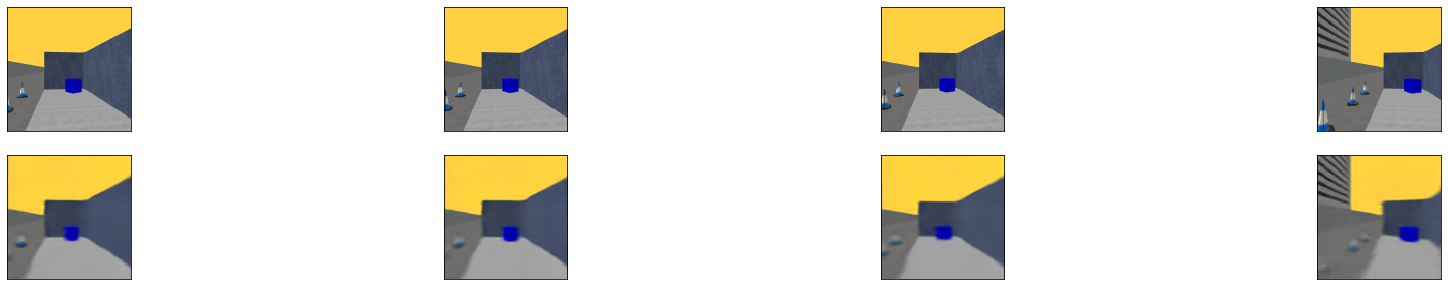

In [0]:



#### EVAL (saving eval.png)#####

decoded_imgs = autoencoder.predict(x_test)


n = 4
plt.figure(figsize=(30, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('eval.png')

import math
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1#255.0
    return mse, 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

n = 80
mses = []
ps = []
for i in range(n):
    mse, p = psnr(x_test[i], decoded_imgs[i])
    mses.append(mse)
    ps.append(p)
print("mean mse: ", np.mean(mses))
print("mean psnr: ", np.mean(ps))
